<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/Milestone_Project_2_Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skimlit

The purpose is to build a NLP Model to read medicatl abstracts easier


In [2]:
!nvidia-smi

Thu Jun 22 10:42:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data
We need to get the data from github

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 13.58 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the pubmed_20K dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
#Start our experiments using the 20k dataset with numbers replaced by "@" sign.
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames=[data_dir + filename for filename in os.listdir(data_dir)]

In [7]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

beome one with the data....We need to visualize

Let's write a function to read in all the lines of a target text file

In [8]:
#Function to read the lines of a document
def get_lines(filename):

  """
  Reads filename ( text file name )and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath
  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    lines=f.readlines()
    return lines



In [9]:
#let's read in the training lines
train_lines=get_lines(data_dir+"train.txt")

In [10]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
len(train_lines)

210040

Let's think about how we want the data to look

How can we the data be best represented
```
[{'line_number': 0,
    'target' : BACKGROUND,
    'text':"Emotional Eating..."
    'total_lines':11}]
```

In [12]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictinaries of abstract line data

  Takes in filename, read it's contens and sorts through each line,
  extracting things like target label, the text of the sentence, how many sentences are in the current abstract, etc
  """
  input_lines=get_lines(filename)# Get all lines fro filename
  abstract_lines="" #Create an empty abstract
  abstract_samples=[]# Create an empty list of abstracts

  #Loop through each line in target file
  for line in input_lines:
    #print(line)
    if line.startswith("###"): #Check the line is an ID line...the abstract is starting
      abstract_id=line
      abstract_lines="" #Reset the abstract string if the line is ID Line
    elif line.isspace(): #Check if the line is a new line
      abstract_line_split=abstract_lines.splitlines()


      #iterate each line in a single abstract and keep count of which line we are on
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")# Split the target label from the text

        line_data['target']=target_text_split[0]
        line_data['text']=target_text_split[1].lower()
        line_data['line_number']=abstract_line_number
        line_data['total_lines']=len(abstract_line_split)-1# How many total lines are there in target abstract
        abstract_samples.append(line_data)

    else: #if the above conditions aren't fulfilled, the lines containes a labelled sentence
      abstract_lines+=line

  return abstract_samples


In [13]:
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 431 ms, sys: 60.1 ms, total: 491 ms
Wall time: 491 ms


(180040, 30212, 30135)

In [14]:
#Check the first abstract of our training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of list of dicts, how about we turn it into dataframe to further visualize it


In [15]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [16]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [17]:
#What is the spread of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

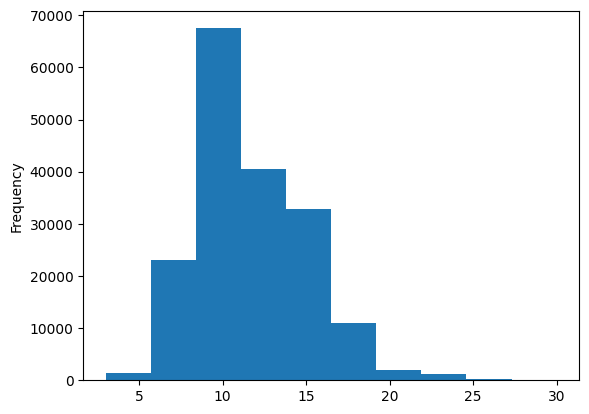

In [18]:
#Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get the list of sentences so that we can work with just the text

In [19]:
#Convert abstract text lines into list
train_sentences=train_df['text'].tolist()
val_sentences=val_df['text'].tolist()
test_sentences=test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML required Numeric labels)



In [21]:
#One hot encoding labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder=OneHotEncoder(sparse=False)

In [22]:
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [24]:
val_labels_one_hot=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

Extract labels("target colums ") and encode them into integer_op_not_supported

In [25]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
test_labels_encoded=label_encoder.transform(test_df['target'].to_numpy())
val_labels_encoded=label_encoder.transform(val_df['target'].to_numpy())

In [26]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [27]:
#Get class names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a seties of modelling experiments

We'll be trying out a bunch of different models to see which one works best...starting with the baseline.
Tf-IDF multinomial naive bayes classifier

### Model 0: Baseline


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("classifier", MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [29]:
#Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [30]:
# Make some predictions using the baseline model
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [31]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [32]:
### Download the helper FUnction Script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-22 10:42:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-22 10:42:57 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [33]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [34]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the text for the Deep Learning Model

Before we start building deep models, we need to create vectorization and embedding layers

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [36]:
#How long is each sentence on average

sent_lens=[len(sentence.split()) for sentence in train_sentences]

In [37]:
avg_sent_len=np.mean(sent_lens)
sent_lens, avg_sent_len

([49,
  27,
  15,
  14,
  35,
  29,
  30,
  55,
  36,
  8,
  32,
  39,
  12,
  26,
  33,
  40,
  22,
  23,
  27,
  26,
  27,
  34,
  41,
  18,
  9,
  23,
  59,
  16,
  18,
  22,
  17,
  51,
  8,
  17,
  16,
  5,
  21,
  4,
  42,
  50,
  11,
  19,
  20,
  29,
  36,
  44,
  39,
  25,
  19,
  24,
  19,
  14,
  11,
  18,
  16,
  26,
  16,
  18,
  38,
  28,
  21,
  18,
  22,
  9,
  37,
  6,
  32,
  21,
  26,
  25,
  18,
  21,
  20,
  12,
  26,
  16,
  23,
  19,
  16,
  39,
  19,
  14,
  37,
  34,
  15,
  47,
  26,
  87,
  17,
  29,
  31,
  13,
  37,
  28,
  35,
  60,
  64,
  66,
  8,
  12,
  17,
  40,
  43,
  37,
  47,
  6,
  40,
  64,
  20,
  32,
  53,
  16,
  30,
  54,
  51,
  19,
  28,
  32,
  36,
  40,
  13,
  25,
  30,
  23,
  17,
  15,
  20,
  50,
  12,
  16,
  27,
  24,
  10,
  24,
  5,
  14,
  19,
  32,
  13,
  21,
  23,
  10,
  11,
  17,
  12,
  21,
  21,
  15,
  17,
  21,
  18,
  40,
  33,
  21,
  41,
  21,
  13,
  29,
  28,
  13,
  44,
  20,
  31,
  8,
  29,
  13,
  116,
  27,
  

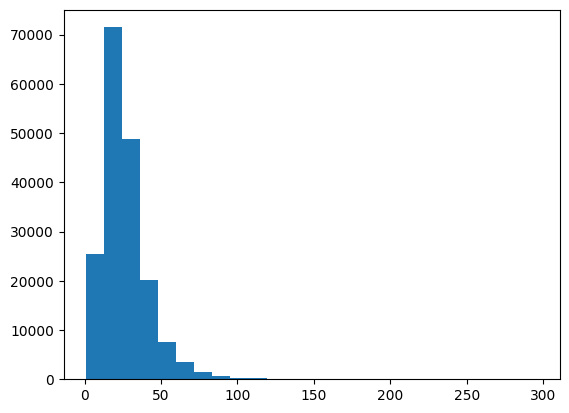

In [38]:
#What does the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [39]:
# How long of a sentence length covers 95& of example?
output_seq_len=int(np.percentile(sent_lens, 95))
output_seq_len

55

In [40]:
max(sent_lens)

296

### Create text vectorizer layer

We need a layer which maps the text to numbers

In [41]:
#How many words in the vocab?
#This is taken form our paper.
max_tokens=68000

In [42]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer= TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=output_seq_len,
                                   )

In [43]:
#Adapt text vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [44]:
#Test out text vectorizer on random sentences
import random
target_sentence=random.choice(train_sentences)
print(f"Text :\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\n Vectorized Text: {text_vectorizer([target_sentence])}")

Text :
from december @ to january @ , @ patients with lumbar disc herniation were treated , including @ males and @ females , ranging in age from @ to @ years ,@ patients with age over @ years old .

Length of text: 191

 Vectorized Text: [[  27 1356    6 1174   12    7 1244 2785 5283    9  172  251 1037    3
  1188 2534    5  103   27    6   64   12    7  103  145   64 1191    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [45]:
#How many in ur training vocab
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in the vocab{len(rct_20k_text_vocab)}")
print(f"Most common word in the vocab {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab{rct_20k_text_vocab[-5:]}")

Number of words in the vocab64841
Most common word in the vocab ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create custom text embedding

In [46]:
#Create token embedding layer
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True,
                             name='token_embedding')

In [47]:
#Show an example embedding
print(f"Sentence before vectorization {target_sentence}")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after vectorization :\n {vectorized_sentence}")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentnece after embedding: {embedded_sentence}")
print(f"Embedded sentnece shape{ embedded_sentence.shape}")


Sentence before vectorization from december @ to january @ , @ patients with lumbar disc herniation were treated , including @ males and @ females , ranging in age from @ to @ years ,@ patients with age over @ years old .
Sentence after vectorization :
 [[  27 1356    6 1174   12    7 1244 2785 5283    9  172  251 1037    3
  1188 2534    5  103   27    6   64   12    7  103  145   64 1191    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentnece after embedding: [[[ 0.0270657   0.00326648  0.03668039 ...  0.03564299 -0.02554638
    0.00139258]
  [ 0.01091468 -0.04189938 -0.04358674 ...  0.03725309  0.0001454
   -0.01592022]
  [-0.0145091  -0.00472327  0.02934518 ... -0.02213485 -0.01404908
   -0.02355744]
  ...
  [-0.0100775  -0.02028205  0.00132627 ...  0.01679994  0.02753606
    0.01320207]
  [-0.0100775  -0.02028205  0.00132627 ...  0.01679994  0.02753606
    0.01320207]
  [-0.0100775  

## Creating Datasets (making sure our data loads as fast as possible)



In [48]:
#Turn our data into tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [49]:
train_labels_one_hot.shape

(180040, 5)

In [50]:
train_dataset= train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with Token Embeddings

In [52]:
#Create 1 D conv model to preocess sequences
inputs=layers.Input(shape=(1,), dtype=tf.string)
text_vectors=text_vectorizer(inputs)

token_embeddings= token_embed(text_vectors)

x=layers.Conv1D(64, kernel_size=5,padding='same', activation='relu')(token_embeddings)

x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes, activation='softmax')(x)

model_1=tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam())



In [53]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [54]:
history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 46s 65ms/step - loss: 0.9138 - accuracy: 0.6404 - val_loss: 0.6860 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6587 - accuracy: 0.7564 - val_loss: 0.6332 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 6s 9ms/step - loss: 0.6161 - accuracy: 0.7742 - val_loss: 0.5947 - val_accuracy: 0.7866


In [55]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5964 - accuracy: 0.7860


[0.596413791179657, 0.786045253276825]

In [56]:
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.4971773e-01, 1.5379515e-01, 6.7086458e-02, 3.0817345e-01,
         2.1227222e-02],
        [4.2499369e-01, 2.8919324e-01, 1.4043634e-02, 2.6123333e-01,
         1.0536083e-02],
        [1.5625767e-01, 4.8458045e-03, 1.7071839e-03, 8.3715308e-01,
         3.6215883e-05],
        ...,
        [6.6845628e-06, 7.2757772e-04, 6.5117807e-04, 3.3660626e-06,
         9.9861121e-01],
        [5.0420675e-02, 4.8307410e-01, 9.7909115e-02, 6.6467747e-02,
         3.0212834e-01],
        [1.8001945e-01, 6.8299031e-01, 4.5287333e-02, 4.3952696e-02,
         4.7750130e-02]], dtype=float32),
 (30212, 5))

In [57]:
model_1_preds=tf.argmax(model_1_pred_probs, axis=1)

In [58]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [59]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [60]:
#Calculate model 1 resuts
model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)

In [61]:
model_1_results

{'accuracy': 78.60452800211837,
 'precision': 0.7831299901451194,
 'recall': 0.7860452800211837,
 'f1': 0.7836651169034649}

## Model 2: Feature extraction with pretrained token embedding

Now let's use pretrained word embeddings from tensorflow hub, more specifically, Univerasl Sentence Encoder

The paper originally used GloVe Embeddings, but we are now going to stick to the Universal Sentence Encoder

In [62]:
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=True,
                                      name='universal_sentence_encoder')

In [63]:
#test pretrained embedding on a random sentence
random_train_sentence=random.choice(train_sentences)
print(f"oriinal Sentence {random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n{use_embedded_sentence}")
print(f"Sentence after embedding length/shape :\n{len(use_embedded_sentence[0])}")



oriinal Sentence overall , @ % of patients achieved remission ( lsas score @ ) at the endpoint , and @ % of patients assigned to sertraline plus clonazepam achieved remission compared with patients assigned to sertraline plus placebo ( @ % ) or venlafaxine ( @ % ) , but the differences did not reach significance .
Sentence after embedding: 
[[-0.05222968 -0.07010733 -0.03355366 -0.05197723  0.0212393   0.0583065
  -0.0150238  -0.02531785  0.00128171  0.04036087  0.07674736 -0.06907564
   0.01730134 -0.03449101  0.03542962  0.02541403 -0.07686752 -0.02883014
  -0.04012771  0.03795328  0.07231668  0.04061534  0.0002701  -0.00888297
   0.03686456  0.00547049  0.03751371 -0.00119627  0.02594996  0.00965058
   0.03506235  0.07686888  0.03269763 -0.02912151  0.01010545  0.04025044
   0.00669214 -0.02548739  0.01327101 -0.0678375  -0.04354259  0.0482631
  -0.02946152 -0.06798961  0.05577556  0.07131981 -0.02215696  0.04792168
   0.04464459  0.04027051 -0.05482124  0.04314456 -0.04225539  0.02

In [64]:
from tensorflow.keras import layers

inputs=layers.Input(shape=[], dtype=tf.string)

pretrained_embedding=tf_hub_embedding_layer(inputs)
x= layers.Dense(128, activation='relu')(pretrained_embedding)
outputs=layers.Dense(num_classes, activation='softmax')(x)

model_2=tf.keras.Model(inputs, outputs, name='model_2_use_feature_extractor')





In [65]:
model_2.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam())

In [66]:
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 223s 337ms/step - loss: 0.7471 - accuracy: 0.7115 - val_loss: 0.5573 - val_accuracy: 0.7862
Epoch 2/3
562/562 [==============================] - 62s 110ms/step - loss: 0.5575 - accuracy: 0.7930 - val_loss: 0.5238 - val_accuracy: 0.7999
Epoch 3/3
562/562 [==============================] - 57s 102ms/step - loss: 0.5256 - accuracy: 0.8040 - val_loss: 0.4926 - val_accuracy: 0.8132


In [67]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs


945/945 [==============================] - 10s 10ms/step


array([[5.22823989e-01, 2.38296725e-02, 3.26924887e-03, 4.49201256e-01,
        8.75846774e-04],
       [4.89804834e-01, 3.71680483e-02, 2.15022126e-03, 4.70221221e-01,
        6.55661628e-04],
       [2.17810929e-01, 3.70055693e-03, 8.96192715e-03, 7.69023657e-01,
        5.02863782e-04],
       ...,
       [2.10242273e-04, 2.57722382e-03, 9.12158377e-03, 1.19335426e-04,
        9.87971604e-01],
       [1.74519103e-02, 6.89916313e-01, 2.84298249e-02, 7.42669124e-03,
        2.56775290e-01],
       [4.65487242e-02, 9.37229097e-01, 4.08374984e-03, 5.79888094e-03,
        6.33956213e-03]], dtype=float32)

In [68]:
model_2_preds=tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [69]:
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_preds)

In [70]:
model_2_results

{'accuracy': 81.28227194492254,
 'precision': 0.8150862173137045,
 'recall': 0.8128227194492255,
 'f1': 0.8128435830042623}

## Model 3: Conv1D with Character level Embeddings

the paper we are replicating states they used a combo of token and char-level embeddings

text_vectorizer works at word level

In [71]:
train_sentences

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [72]:
def split_chars(text):
  return " ".join(list(text))




In [73]:
#Text splitting non-character level seq into characters
split_chars(random_train_sentence)

'o v e r a l l   ,   @   %   o f   p a t i e n t s   a c h i e v e d   r e m i s s i o n   (   l s a s   s c o r e   @   )   a t   t h e   e n d p o i n t   ,   a n d   @   %   o f   p a t i e n t s   a s s i g n e d   t o   s e r t r a l i n e   p l u s   c l o n a z e p a m   a c h i e v e d   r e m i s s i o n   c o m p a r e d   w i t h   p a t i e n t s   a s s i g n e d   t o   s e r t r a l i n e   p l u s   p l a c e b o   (   @   %   )   o r   v e n l a f a x i n e   (   @   %   )   ,   b u t   t h e   d i f f e r e n c e s   d i d   n o t   r e a c h   s i g n i f i c a n c e   .'

In [74]:
train_chars=[split_chars(sentence) for sentence in train_sentences]
train_chars[:5]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [75]:
#What's the average character length

char_lens= [len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

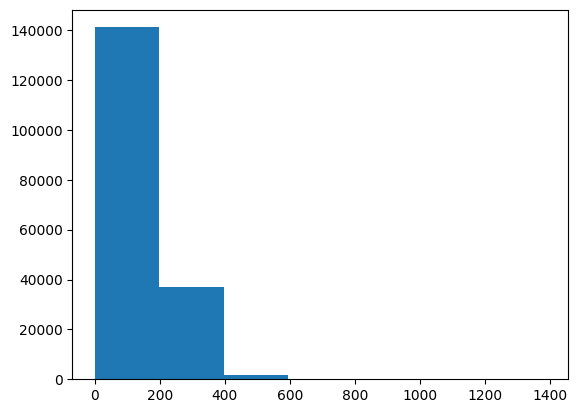

In [76]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [77]:
#Find what character length covers 95% of the sequences
output_seq_char_len=int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [78]:
# Get all keyboard characters
import string
alphabet=string.ascii_lowercase + string.digits + string.punctuation

In [79]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [80]:
#Create char level token vectorizer
NUM_CHAR_TOKENS=len(alphabet)+2 #Add 2 for space and OOV Token
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vectorizer')

In [81]:
char_vectorizer.adapt(train_chars)

In [82]:
#Check character vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"No. of different chars in character vocab : {len(char_vocab)}")
print(f"5 most common characters {char_vocab[:5]}")
print(f"5 least common chars{char_vocab[-5:]}")

No. of different chars in character vocab : 28
5 most common characters ['', '[UNK]', 'e', 't', 'i']
5 least common chars['k', 'x', 'z', 'q', 'j']


In [83]:
random_chars=random.choice(train_chars)
print(f"charified text: {random_chars}")
print(f"\nLength of random_train_chars{len(random_chars)}")
vectorized_chars=char_vectorizer([random_chars])
print(f"\nVectorized Characters{vectorized_chars }")
print(f"\nLength Vectorized Characters{len(vectorized_chars[0]) }")

charified text: m e d i a n   r r   a n d   m e a n   b p   (   m b p   )   w e r e   l o w e r   i n   t h e   l i d o c a i n e   c o m p a r e d   w i t h   t h e   s a l i n e   t r e a t e d   g r o u p   .

Length of random_train_chars195

Vectorized Characters[[15  2 10  4  5  6  8  8  5  6 10 15  2  5  6 22 14 15 22 14 20  2  8  2
  12  7 20  2  8  4  6  3 13  2 12  4 10  7 11  5  4  6  2 11  7 15 14  5
   8  2 10 20  4  3 13  3 13  2  9  5 12  4  6  2  3  8  2  5  3  2 10 18
   8  7 16 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character level embedding


In [84]:
#Create char embedding layer
char_embed= layers.Embedding(input_dim=len(char_vocab),
                             output_dim=25,#This is the size of the char embedding in the paper
                             mask_zero=True,
                             name='char_embed')

In [85]:
print(f"charified text:{random_chars}")
char_embed_example=char_embed(char_vectorizer([random_chars]))
print(f"\nEmbedded char example {char_embed_example}")
print(f"\nChar embedding example shape :{char_embed_example.shape}")

charified text:m e d i a n   r r   a n d   m e a n   b p   (   m b p   )   w e r e   l o w e r   i n   t h e   l i d o c a i n e   c o m p a r e d   w i t h   t h e   s a l i n e   t r e a t e d   g r o u p   .

Embedded char example [[[ 0.00403565 -0.01122621 -0.02159449 ... -0.0172287  -0.04923318
   -0.03148359]
  [-0.01959103 -0.02678726 -0.04167291 ... -0.00442276  0.02522904
   -0.00061518]
  [-0.0466531  -0.00547821  0.02997461 ... -0.04887651 -0.02136449
    0.03124904]
  ...
  [-0.03117343 -0.01679891  0.00235109 ... -0.00595375 -0.03574301
   -0.00157442]
  [-0.03117343 -0.01679891  0.00235109 ... -0.00595375 -0.03574301
   -0.00157442]
  [-0.03117343 -0.01679891  0.00235109 ... -0.00595375 -0.03574301
   -0.00157442]]]

Char embedding example shape :(1, 290, 25)


## Building a Conv1D model to fit on the char embeddings

In [86]:
inputs=layers.Input(shape=(1,), dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embedding= char_embed(char_vectors)
x=layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(char_embedding)

x=layers.GlobalAveragePooling1D()(x)

outputs=layers.Dense(num_classes, activation='softmax')(x)

model_3=tf.keras.Model(inputs, outputs,name='model_3_Conv1DModel_char_embedding')

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_3_Conv1DModel_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (No

In [87]:
#Create char level dataset
train_char_dataset= tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset= tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [88]:
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.4576 - accuracy: 0.3490 - val_loss: 1.4062 - val_accuracy: 0.3956
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3683 - accuracy: 0.4182 - val_loss: 1.3362 - val_accuracy: 0.4441
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3267 - accuracy: 0.4501 - val_loss: 1.3192 - val_accuracy: 0.4385


If globalAveragePolling isn't working, try to change that to max pool

In [89]:
#Make predictions with character model only
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.17714569, 0.24780835, 0.25527883, 0.14675748, 0.17300965],
       [0.1116869 , 0.15994611, 0.19064634, 0.06686967, 0.47085094],
       [0.09781374, 0.1597652 , 0.3914578 , 0.09334248, 0.25762075],
       ...,
       [0.05354062, 0.1018663 , 0.2136171 , 0.04498776, 0.5859882 ],
       [0.03839037, 0.09749281, 0.1688851 , 0.05066993, 0.64456177],
       [0.14292708, 0.17770924, 0.20169961, 0.06974403, 0.40792003]],
      dtype=float32)

In [90]:
model_3_preds=tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [91]:
model_3_results=calculate_results(y_true=val_labels_encoded,
                  y_pred=model_3_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
model_3_results

{'accuracy': 44.31351780749371,
 'precision': 0.3749740141398058,
 'recall': 0.44313517807493713,
 'f1': 0.3869446354567605}

## Multimodal- Inputs from multiple different data sources.

1. Create a token level embedding
2. Create a character level embedding( similar to model 3...with a slight modification
3. Combine the models with a concatenate (layers.Concatenate)
4. Build a series of output layers on top of model 3
5. Construct a model that taken token and char-level sequences as inputs and produces sequence label probabs as outputs

In [93]:
# 1. Setup token inputs/model
token_inputs= layers.Input(shape=[], dtype=tf.string, name='token_input')

token_embeddings=tf_hub_embedding_layer(token_inputs) #Using the USE rmbeddings

token_output=layers.Dense(128, activation='relu')(token_embeddings)
token_model=tf.keras.Model(token_inputs, token_output)

# 2. Setup char inputs/model
char_inputs=layers.Input(shape=(1,), dtype=tf.string)

char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)

char_bi_lstm= layers.Bidirectional(layers.LSTM(24, activation='tanh'))(char_embeddings)

char_model=tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Combine the 2 models with concatenate
token_char_concat=layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layer - adding Dropout
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combine_dense=layers.Dense(128, activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combine_dense)

output_layer=layers.Dense(num_classes)(final_dropout)

model_4=tf.keras.Model(inputs=[token_model.input, char_model.input],
                       outputs=output_layer,
                       name='model_4_token_and_char_embeddings')

In [94]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

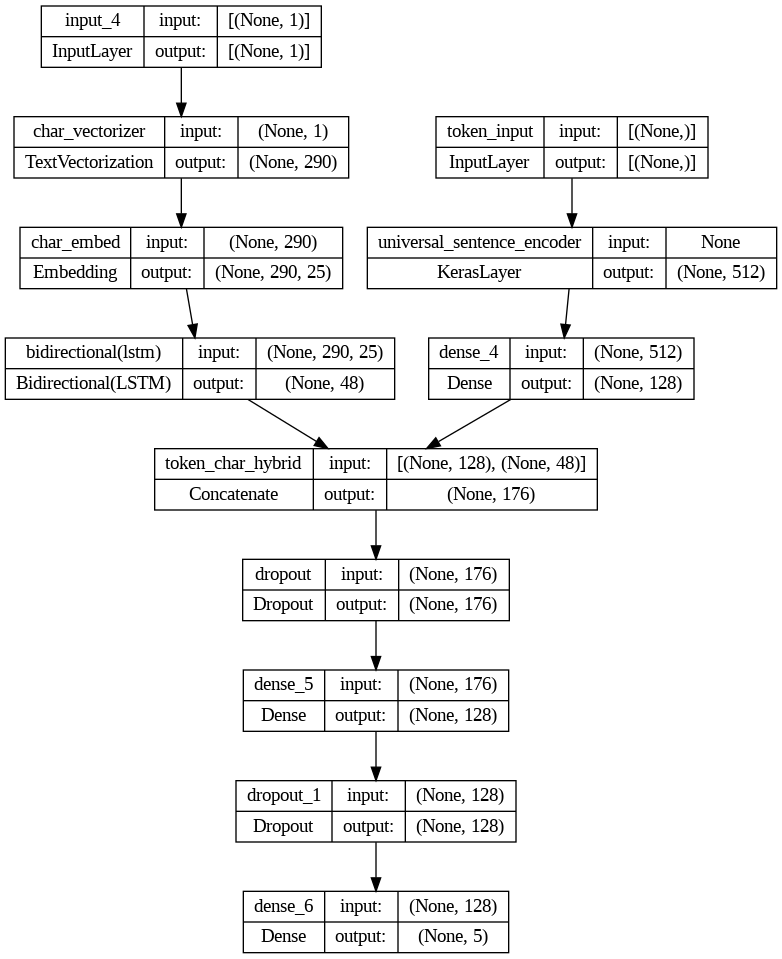

In [95]:
#Plot Hybrid Token and character model

from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [114]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


### Combining token and character data into a tf.data Dataset


In [115]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [116]:
# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [117]:
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character level sequences

In [119]:
#Fit the model on tokens and chars
history_model_4=model_4.fit(train_char_token_dataset,
                             steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                             epochs=3,
                             validation_data=val_char_token_dataset,
                             validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 302s 441ms/step - loss: 4.7511 - accuracy: 0.2657 - val_loss: 1.2813 - val_accuracy: 0.0209
Epoch 2/3
562/562 [==============================] - 99s 176ms/step - loss: 2.2816 - accuracy: 0.2794 - val_loss: 1.4001 - val_accuracy: 0.0838
Epoch 3/3
562/562 [==============================] - 94s 167ms/step - loss: 1.7927 - accuracy: 0.3011 - val_loss: 1.0057 - val_accuracy: 0.3348


In [119]:
#Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

In [120]:
#Make predictions using the token-character model hybrid
model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 23ms/step


array([[ 1.1713738 ,  1.2773771 ,  1.3403716 ,  0.88246566,  0.81756485],
       [ 1.1172992 ,  1.1731638 ,  1.164629  ,  0.79729295,  0.63077533],
       [ 1.034408  ,  1.0821455 ,  1.0699428 ,  0.7838513 ,  0.60593534],
       ...,
       [-1.3408695 , -1.0277689 ,  2.9283123 , -1.3080858 ,  2.6085696 ],
       [-0.534948  , -0.29075256,  2.1631756 , -0.5854318 ,  1.8048295 ],
       [ 1.1356742 ,  1.295278  ,  1.3783761 ,  0.83927673,  0.91706395]],
      dtype=float32)

In [125]:
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)

In [126]:
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 1, 1, ..., 2, 2, 2])>

In [1]:
model_4_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_4_preds)

NameError: ignored

In [ ]:
model_4_results